In [14]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from kernels import K_classical, K_simple_RX, K_phi_RX, K_layered, K_L_tower, K_L_prod, K_L_cheb
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit_aer.noise import NoiseModel
import pennylane as qml

In [15]:
backend = GenericBackendV2(num_qubits=8)
noise_model = NoiseModel.from_backend(backend)

kernels = {
    'RBF': K_classical(0.20),
    '2L-prod': K_L_prod(N=8, n_layers=2),
    '2L-tower': K_L_cheb(N=8, n_layers=2),
    '2L-cheb' :K_L_tower(N=8, n_layers=2),
    '1L-prod': K_L_prod(N=8, n_layers=1),
    '1L-tower': K_L_cheb(N=8, n_layers=1),
    '1L-cheb' :K_L_tower(N=8, n_layers=1),
    'K_XYZ': K_layered(N=8, n_layers=3),
}

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

/Users/leonardeyer/Documents/Notes/Uni/Applied Quantum Algorithms/Project/QKM/venv/lib/python3.10/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in arccos
  return f_raw(*args, **kwargs)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

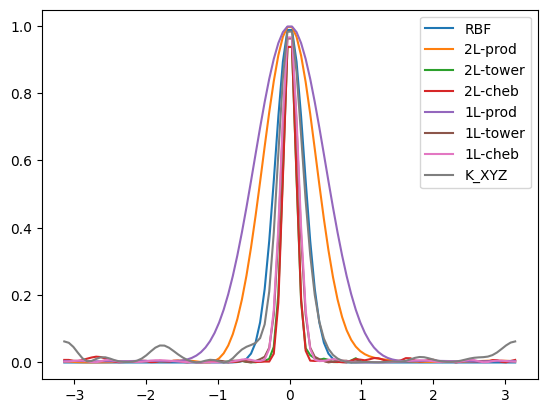

In [16]:
# compare the kernels
xs = np.linspace(-np.pi, np.pi, 100)

for label, kernel in kernels.items():
    plt.plot(xs, [kernel(x, 0) for x in tqdm(xs)], label=label)

plt.legend()
plt.show()

In [17]:
def make_gradient_kernel(kernel):
    def f(params):
        return kernel(params[0], params[1])
    
    def grad_f(params):
        params = np.array(params, requires_grad=True)
        return qml.jacobian(f)(params)
    
    return grad_f

def variance(f, params, N):
    values = [f(params) for _ in tqdm(range(N))]
    return np.var(values)

In [18]:
def make_DE(llambda, kk):
    def df_dx(x, f, l, k):
        return -l * k * f -l * np.exp(-l * k * x) * np.sin(l * x)
    
    def DE(x, f, dfdx):
        return dfdx - df_dx(x, f, llambda, kk)
    
    def f_sol(x):
        return np.exp(-llambda * kk * x) * np.cos(llambda * x)
    
    return DE, f_sol

llambda = 20
kk = 0.1

DE, sol = make_DE(llambda, kk)

  0%|          | 0/8 [00:00<?, ?it/s]

Running RBF
Optimization terminated successfully.
         Current function value: 1.160979
         Iterations: 15
         Function evaluations: 24
         Gradient evaluations: 275
         Hessian evaluations: 0


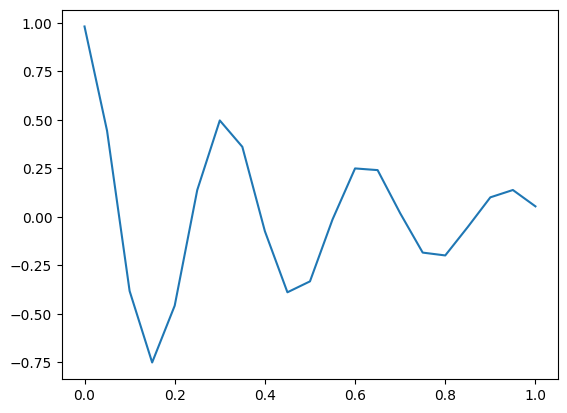

Running 2L-prod
Optimization terminated successfully.
         Current function value: 507.628835
         Iterations: 9
         Function evaluations: 15
         Gradient evaluations: 276
         Hessian evaluations: 0


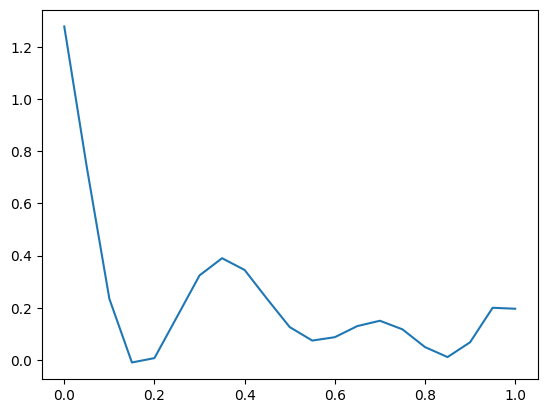

Running 2L-tower


/Users/leonardeyer/Documents/Notes/Uni/Applied Quantum Algorithms/Project/QKM/venv/lib/python3.10/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: invalid value encountered in divide
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/leonardeyer/Documents/Notes/Uni/Applied Quantum Algorithms/Project/QKM/venv/lib/python3.10/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: divide by zero encountered in divide
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/leonardeyer/Documents/Notes/Uni/Applied Quantum Algorithms/Project/QKM/venv/lib/python3.10/site-packages/scipy/optimize/_optimize.py:2104: OptimizeWarning: Warning: CG iterations didn't converge. The Hessian is not positive definite.
  return terminate(3, msg)


         Current function value: nan
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 880
         Hessian evaluations: 0


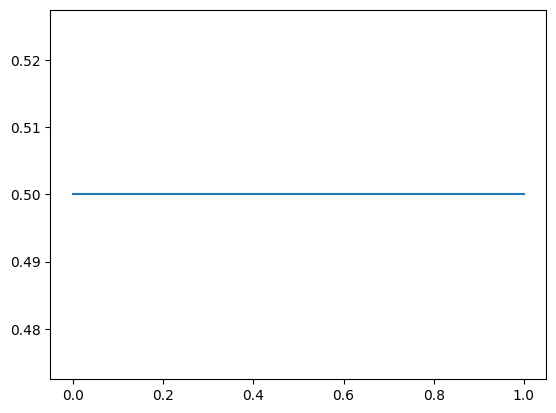

Running 2L-cheb
         Current function value: 0.000294
         Iterations: 13
         Function evaluations: 14
         Gradient evaluations: 1774
         Hessian evaluations: 0


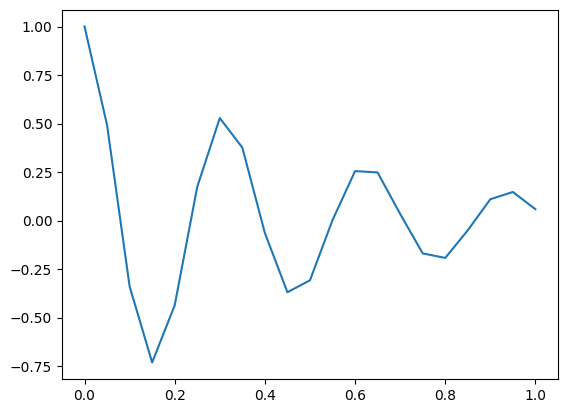

Running 1L-prod
         Current function value: 796.941663
         Iterations: 10
         Function evaluations: 14
         Gradient evaluations: 1003
         Hessian evaluations: 0


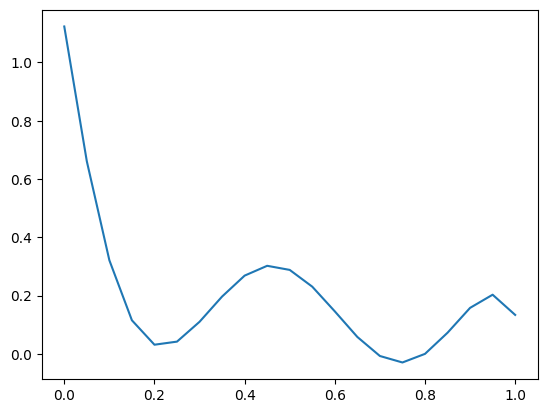

Running 1L-tower
         Current function value: nan
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 880
         Hessian evaluations: 0


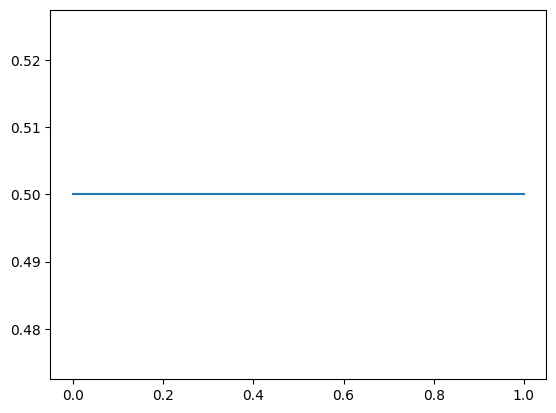

Running 1L-cheb
         Current function value: 0.000386
         Iterations: 11
         Function evaluations: 12
         Gradient evaluations: 1278
         Hessian evaluations: 0


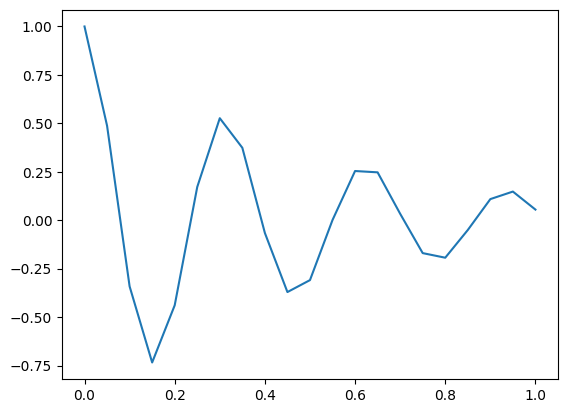

Running K_XYZ
         Current function value: 0.050565
         Iterations: 14
         Function evaluations: 20
         Gradient evaluations: 1703
         Hessian evaluations: 0


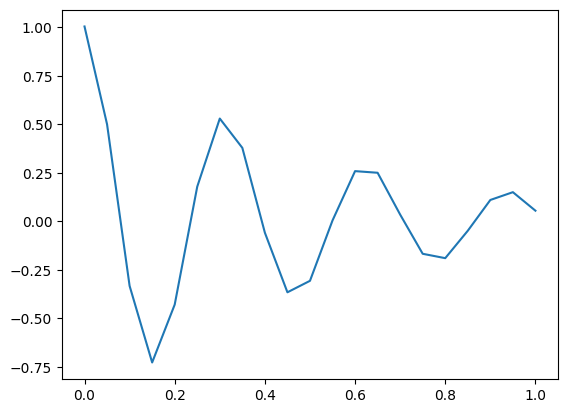

In [19]:
from optim import multivalued_mmr_DE

x = np.linspace(0, 1, 21).reshape(21, 1)
y = x
xs = np.reshape(x, (len(x), -1))
results = {}

for label, kernel in tqdm(kernels.items()):
    print(f'Running {label}')
    f_sol = multivalued_mmr_DE(DE=DE, data=[x, y], x0=np.array([0.]), f0=np.array([1.]), K=kernel)

    results[label] = [f_sol(x) for x in xs]
    
    plt.plot(xs, results[label], label=label)
    plt.show()
